# Harmonisation resdiuals plots for both CLIM and NO-CLIM models.


In [2]:
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
from odc.geo.xr import assign_crs

import sys
sys.path.append('/g/data/os22/chad_tmp/AusEFlux/src/')
from _utils import round_coords

# Using ggplot styles in this notebook
plt.style.use('ggplot')

%matplotlib inline

## Analysis Parameters

In [3]:
model_var='NDVI'

type = 'LGBM'

crs='epsg:4326'

base = '/g/data/os22/chad_tmp/AusENDVI/data/'

## Open datasets

In [4]:
if type == 'LGBM':
    open_var='NDVI'
else:
    open_var='ndvi_mcd_pred'
    
trees = xr.open_dataset(f'{base}NDVI_harmonization/{type}/NDVI_trees_CLIM_{type}_harmonize_5km_monthly_1982_2013.nc')[open_var]
nontrees = xr.open_dataset(f'{base}/NDVI_harmonization/{type}/NDVI_nontrees_CLIM_{type}_harmonize_5km_monthly_1982_2013.nc')[open_var]
desert = xr.open_dataset(f'{base}/NDVI_harmonization/{type}/NDVI_desert_CLIM_{type}_harmonize_5km_monthly_1982_2013.nc')[open_var]
merge_clim = xr.where(np.isnan(trees), nontrees, trees)
merge_clim = xr.where(np.isnan(desert), merge_clim, desert)
merge_clim = assign_crs(merge_clim, crs=crs)
merge_clim = merge_clim.rename('NDVI')

trees = xr.open_dataset(f'{base}NDVI_harmonization/{type}/NDVI_trees_NOCLIM_{type}_harmonize_5km_monthly_1982_2013.nc')[open_var]
nontrees = xr.open_dataset(f'{base}/NDVI_harmonization/{type}/NDVI_nontrees_NOCLIM_{type}_harmonize_5km_monthly_1982_2013.nc')[open_var]
desert = xr.open_dataset(f'{base}/NDVI_harmonization/{type}/NDVI_desert_NOCLIM_{type}_harmonize_5km_monthly_1982_2013.nc')[open_var]
merge_noclim = xr.where(np.isnan(trees), nontrees, trees)
merge_noclim = xr.where(np.isnan(desert), merge_noclim, desert)
merge_noclim = assign_crs(merge_noclim, crs=crs)
merge_noclim = merge_noclim.rename('NDVI')

avhrr = xr.open_dataset(base+model_var+'_harmonization/AVHRR_'+model_var+'_5km_monthly_1982_2013.nc')[model_var+'_avhrr']
avhrr = assign_crs(avhrr, crs=crs)
avhrr = round_coords(avhrr)

modis = xr.open_dataset(base+model_var+'_harmonization/MODIS_'+model_var+'_5km_monthly_200003_202212.nc')[model_var+'_median']
modis = assign_crs(modis, crs=crs)
modis = round_coords(modis)

### Combine trees, nontrees and desert model predictions (unless LST)

In [5]:
#ensure we only have data where there is AVHRR data (this is unnecessary but being sure)
avhrr_mask = xr.open_dataarray(f'{base}{model_var}_harmonization/AVHRR_{model_var}_filtered_mask_1982_2013.nc')
avhrr_mask = round_coords(avhrr_mask)
merge_clim = merge_clim.where(avhrr_mask)
merge_noclim = merge_noclim.where(avhrr_mask)

#clip MODIS to same areas/time
modis = modis.sel(time=slice('2000', '2013')).where(avhrr_mask.sel(time=slice('2000-03', '2013')))

#modis has very slightly different extent so clip further
modis_mask = ~np.isnan(modis)
merge_clim = merge_clim.sel(time=modis.time).where(modis_mask)
merge_noclim = merge_noclim.sel(time=modis.time).where(modis_mask)
avhrr = avhrr.sel(time=modis.time)
avhrr = avhrr.where(modis_mask)

## Residuals through time



In [9]:
#residuals after harmonization
residual_clim = (modis - merge_clim).mean(['latitude', 'longitude']).drop('spatial_ref').to_dataframe(name='CLIM')
residual_sd_clim = (modis - merge_clim).std(['latitude', 'longitude']).drop('spatial_ref').to_dataframe(name='CLIM')

residual_noclim = (modis - merge_noclim).mean(['latitude', 'longitude']).drop('spatial_ref').to_dataframe(name='NOCLIM')
residual_sd_noclim = (modis - merge_noclim).std(['latitude', 'longitude']).drop('spatial_ref').to_dataframe(name='NOCLIM')

#residuals before harmonization
residual_b = (modis - avhrr).mean(['latitude', 'longitude']).drop('spatial_ref').to_dataframe(name='CDR')
residual_sd_b = (modis - avhrr).std(['latitude', 'longitude']).drop('spatial_ref').to_dataframe(name='CDR')

/jobfs/107630182.gadi-pbs/ipykernel_320105/1209016608.py:2: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  residual_clim = (modis - merge_clim).mean(['latitude', 'longitude']).drop('spatial_ref').to_dataframe(name='CLIM')
/jobfs/107630182.gadi-pbs/ipykernel_320105/1209016608.py:3: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  residual_sd_clim = (modis - merge_clim).std(['latitude', 'longitude']).drop('spatial_ref').to_dataframe(name='CLIM')
/jobfs/107630182.gadi-pbs/ipykernel_320105/1209016608.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  residual_noclim = (modis - merge_noclim).mean(['latitude', 'longitude']).drop('spatial_ref').to_dataframe(name='NOCLIM')
/jobfs/107630182.gadi-pbs/ipykernel_320105/1209016608.py:6: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  residual_sd_noclim = (modis - merge_noclim).std(['latitude', 'longitude

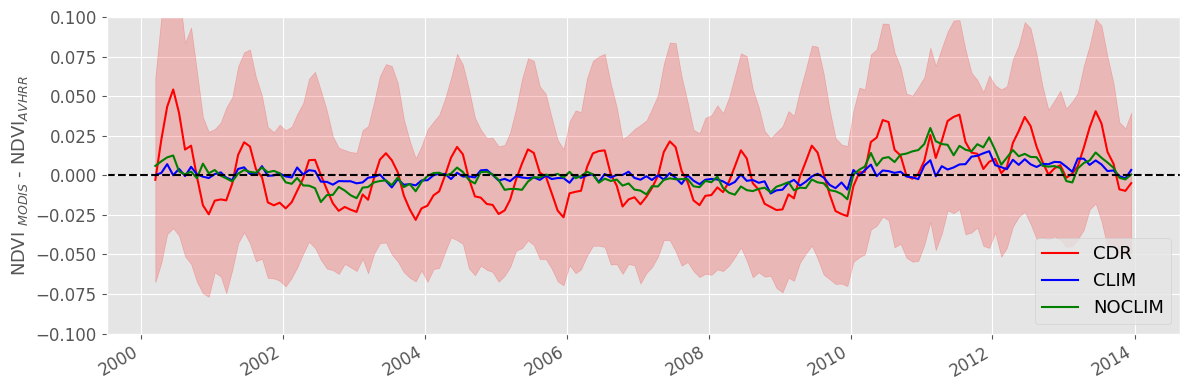

In [17]:
fig,ax = plt.subplots(1,1, figsize=(12,4), sharex=True)

residual_b.plot(ax=ax, legend=False, color='red')
ax.fill_between(residual_b.index, (residual_b-residual_sd_b)['CDR'],
                   (residual_b+residual_sd_b)['CDR'], alpha=0.2, color='red')

residual_clim.plot(ax=ax, legend=False, color='blue')
# ax.fill_between(residual.index, (residual-residual_sd)['After'],
#                 (residual+residual_sd)['After'], alpha=0.15, color='blue')

residual_noclim.plot(ax=ax, legend=False, color='green')

ax.axhline(0.0, color='k', linestyle='--')
ax.legend(loc='lower right', fontsize=13)
ax.set_title(None)

ax.set_ylim(-0.1, 0.1)
ax.set_ylabel(model_var+" $_{MODIS}$"+ " - "+model_var+"$_{AVHRR}$", fontsize=13)
ax.set_xlabel(None)
ax.tick_params(axis='y', labelsize=12)
ax.tick_params(axis='x', labelsize=12)

plt.tight_layout()
fig.savefig(f'/g/data/os22/chad_tmp/AusENDVI/results/figs/{model_var}_compare_clim-noclim_residuals.png',
            bbox_inches='tight', dpi=300);